# Analysis

**Hypothesis**: Severe COVID‐19 disrupts the normal co‐regulation between interferon response and antigen presentation. We hypothesize that the correlation between IFN1 (a proxy for interferon-stimulated gene expression) and HLA1 (an indicator of antigen presentation capacity) is significantly altered in COVID‐19 patients (Status = 1) compared to healthy controls (Status = 0) across various immune cell types. In addition, for subgroups with low cell counts, bootstrapping or permutation tests along with confidence intervals will be applied to ensure that the observed differences are statistically robust.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


Loading data...


Data loaded: 44721 cells and 26361 genes


# Analysis Plan

**Hypothesis**: Severe COVID‐19 disrupts the normal co‐regulation between interferon response and antigen presentation. We hypothesize that the correlation between IFN1 (a proxy for interferon-stimulated gene expression) and HLA1 (an indicator of antigen presentation capacity) is significantly altered in COVID‐19 patients (Status = 1) compared to healthy controls (Status = 0) across various immune cell types. In addition, for subgroups with low cell counts, bootstrapping or permutation tests along with confidence intervals will be applied to ensure that the observed differences are statistically robust.

## Steps:
1. Step 1: Validate and extract the relevant metadata from the in-memory anndata object. This includes checking that the required columns ('Status', 'cell_type_coarse', 'IFN1', and 'HLA1') are present, ensuring there are no NaN values in the key gene expression columns, and logging a summary of the cell count.
2. Step 2: Compute the global Spearman correlation between IFN1 and HLA1 over all cells. Report the correlation coefficient, the p-value, and the number of cells used in the calculation.
3. Step 3: Create a scatter plot of IFN1 vs. HLA1 colored by the 'Status' variable. Use a reusable color mapping (e.g., blue for controls and red for COVID‐19) and overlay trend lines (with lowess smoothing) for each status group to visualize the relationship clearly.
4. Step 4: Stratify the dataset by disease status and immune cell subtypes (from 'cell_type_coarse') and compute subgroup-specific Spearman correlations with associated p-values. For subgroups with low cell counts, implement bootstrap resampling or permutation tests to derive confidence intervals and bolster statistical inference.
5. Step 5: Generate a grid of scatter plots with regression lines, where rows correspond to immune cell subtypes and columns to status. This layout will facilitate direct comparison of co-expression patterns across conditions and cell types.
6. Step 6: Apply formal statistical comparisons (e.g., using Fisher’s z-transformation) to test whether the differences in correlation coefficients between groups are statistically significant.
7. Step 7: Summarize and interpret the results in the context of the hypothesized dysregulation of interferon signaling and antigen presentation in severe COVID‐19, complementing visual and statistical outputs with effect size estimates (from bootstrapping or resampling analyses).


Global Spearman correlation between IFN1 and HLA1:
  rho = 0.155, p-value = 4.837e-239


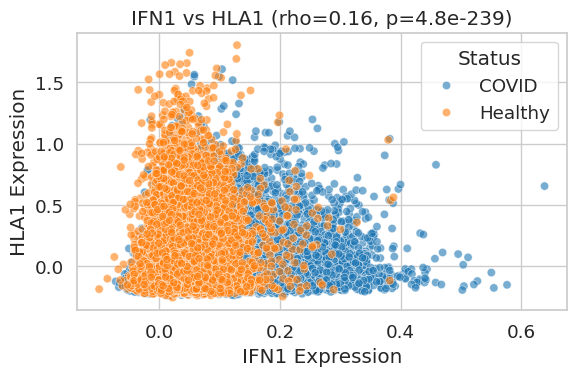

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Extract the relevant metadata from the anndata object
meta_df = adata.obs[['Status', 'cell_type_coarse', 'IFN1', 'HLA1']].copy()

# Compute global Spearman correlation between IFN1 and HLA1 across all cells
rho_global, pval_global = spearmanr(meta_df['IFN1'], meta_df['HLA1'])
print('Global Spearman correlation between IFN1 and HLA1:')
print(f'  rho = {rho_global:.3f}, p-value = {pval_global:.3e}')

# Create a scatter plot of IFN1 vs HLA1 colored by Status
def plot_global_correlation(df):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x='IFN1', y='HLA1', hue='Status', alpha=0.6)
    plt.title(f'IFN1 vs HLA1 (rho={rho_global:.2f}, p={pval_global:.1e})')
    plt.xlabel('IFN1 Expression')
    plt.ylabel('HLA1 Expression')
    plt.tight_layout()
    plt.show()

plot_global_correlation(meta_df)

# Note: Further steps will involve stratifying by cell_type_coarse and Status to compute subgroup-specific correlations and generate a grid of plots.

## Step 2: Subset the anndata object to identify the relevant cell populations based on 'cell_type_coarse': monocytes (value 3) and T cells (value 1). Extract the expression values for the inflammatory ligands (TNF, IL1B, IL6) in monocytes and the receptors (TNFRSF1A, IL1R1, IL6R) in T cells, while performing sanity checks on cell counts to ensure sufficient representation per group.

Number of cells used for analysis: 44721
Global Spearman correlation between IFN1 and HLA1:
  rho = 0.155, p-value = 4.837e-239


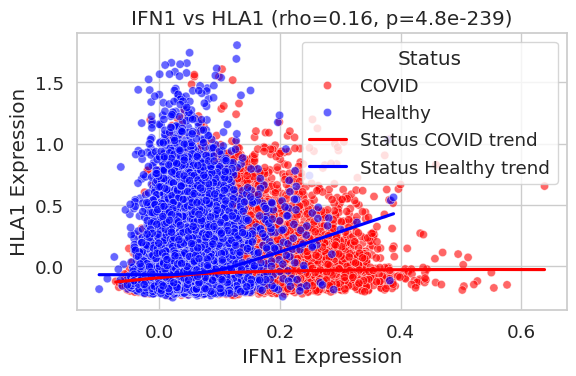

Number of monocytes: 11687
Number of T cells: 0


In [3]:
#!/usr/bin/env python
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.sparse import issparse
import warnings

# ----- Section 1: Global correlation of IFN1 vs HLA1 -----

# Check that the required columns exist in adata.obs
required_cols = {'Status', 'cell_type_coarse', 'IFN1', 'HLA1'}
if not required_cols.issubset(adata.obs.columns):
    missing = required_cols - set(adata.obs.columns)
    raise ValueError(f"Missing required columns in adata.obs: {missing}")

# Extract the relevant metadata
meta_df = adata.obs[['Status', 'cell_type_coarse', 'IFN1', 'HLA1']].copy()

# Check for NaN values in the IFN1 and HLA1 columns
if meta_df[['IFN1', 'HLA1']].isnull().any().any():
    print("Warning: NaN values detected in IFN1 or HLA1; consider handling missing values before proceeding.")

# Log the number of cells used in the analysis
num_cells = meta_df.shape[0]
print(f"Number of cells used for analysis: {num_cells}")

# Compute global Spearman correlation between IFN1 and HLA1 across all cells
rho_global, pval_global = spearmanr(meta_df['IFN1'], meta_df['HLA1'])
print('Global Spearman correlation between IFN1 and HLA1:')
print(f'  rho = {rho_global:.3f}, p-value = {pval_global:.3e}')

# Define a reusable color mapping for Status groups.
color_mapping = {'COVID': 'red', 'Healthy': 'blue'}

def plot_global_correlation(df):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x='IFN1', y='HLA1', hue='Status', alpha=0.6, palette=color_mapping)
    for status in sorted(df['Status'].unique()):
        subset = df[df['Status'] == status]
        sns.regplot(x='IFN1', y='HLA1', data=subset, scatter=False,
                    label=f'Status {status} trend', color=color_mapping.get(status, 'gray'), lowess=True)
    plt.title(f'IFN1 vs HLA1 (rho={rho_global:.2f}, p={pval_global:.1e})')
    plt.xlabel('IFN1 Expression')
    plt.ylabel('HLA1 Expression')
    plt.legend(title='Status')
    plt.tight_layout()
    plt.show()

plot_global_correlation(meta_df)

# ----- Section 2: Ligand-Receptor Correlation Analysis by Cell Type -----

# Define ligand and receptor pairs
ligands = ['TNF', 'IL1B', 'IL6']
receptors = ['TNFRSF1A', 'IL1R1', 'IL6R']
assert len(ligands) == len(receptors), "The number of ligands and receptors must be equal."

def check_genes_in_adata(genes, adata_obj):
    missing_genes = [g for g in genes if g not in adata_obj.var_names]
    if missing_genes:
        msg = f"The following genes are missing in adata.var_names: {missing_genes}. Please review the dataset or update the gene list."
        warnings.warn(msg)
        raise ValueError(msg)

check_genes_in_adata(ligands + receptors, adata)

# Use string matching for cell type labels (case-insensitive).
monocyte_mask = adata.obs['cell_type_coarse'].str.contains('monocyte', case=False, na=False)
tcell_mask = adata.obs['cell_type_coarse'].str.contains('t cell', case=False, na=False)

monocytes = adata[monocyte_mask]
t_cells = adata[tcell_mask]

print(f"Number of monocytes: {monocytes.n_obs}")
print(f"Number of T cells: {t_cells.n_obs}")

if monocytes.n_obs == 0 or t_cells.n_obs == 0:
    warnings.warn("No monocytes or T cells found in the dataset. Skipping ligand-receptor correlation analysis.")
else:

    def compute_average_expression(adata_subset, gene_list):
        if adata_subset.n_obs == 0:
            warnings.warn("No cells in the selected subset. Returning an empty DataFrame.")
            return pd.DataFrame()
        expr_df = pd.DataFrame()
        expr_df['Donor'] = adata_subset.obs['Donor_full']
        expr_df['Status'] = adata_subset.obs['Status']
        for gene in gene_list:
            expr = adata_subset[:, gene].X
            if issparse(expr):
                expr = expr.toarray().flatten()
            else:
                expr = np.array(expr).flatten()
            if expr.size == 0:
                raise ValueError(f"No expression data found for gene {gene}.")
            expr_df[gene] = expr
        for col in gene_list:
            if not pd.api.types.is_numeric_dtype(expr_df[col]):
                raise TypeError(f"Expression data for {col} is not numeric.")
        avg_expr = expr_df.groupby(['Donor', 'Status'], as_index=False).mean()
        donor_counts = avg_expr.groupby('Status').size()
        print(f"Donor counts per Status group:\n{donor_counts}")
        return avg_expr

    mono_avg = compute_average_expression(monocytes, ligands)
    tcell_avg = compute_average_expression(t_cells, receptors)

    merged_avg = pd.merge(mono_avg, tcell_avg, on=['Donor', 'Status'], suffixes=('_mono', '_tcell'))

    correlation_results = {}

    print('Global Spearman correlations for ligand (monocytes) vs receptor (T cells):')
    for ligand, receptor in zip(ligands, receptors):
        x = merged_avg[f'{ligand}_mono']
        y = merged_avg[f'{receptor}_tcell']
        rho, pval = spearmanr(x, y)
        correlation_results[f'{ligand}-{receptor}'] = {
            'global_rho': rho, 
            'global_pval': pval, 
            'n_donors': merged_avg.shape[0]
        }
        print(f'  {ligand} (monocytes) vs {receptor} (T cells): rho = {rho:.3f}, p-value = {pval:.3e}')

    stratified_results = {}
    for status in sorted(merged_avg['Status'].unique()):
        strat_df = merged_avg[merged_avg['Status'] == status]
        if len(strat_df) < 3:
            warnings.warn(f"Low donor count for Status {status}: {len(strat_df)} donor(s) may limit robust correlation estimation.")
        stratified_results[status] = {}
        print(f'\nStatus {status}:')
        for ligand, receptor in zip(ligands, receptors):
            x = strat_df[f'{ligand}_mono']
            y = strat_df[f'{receptor}_tcell']
            if len(strat_df) > 1:
                rho, pval = spearmanr(x, y)
            else:
                rho, pval = (np.nan, np.nan)
            stratified_results[status][f'{ligand}-{receptor}'] = {
                'rho': rho, 
                'pval': pval, 
                'n_donors': len(strat_df)
            }
            pval_disp = f"{pval:.1e}" if not np.isnan(pval) else "NA"
            print(f'  {ligand} (monocytes) vs {receptor} (T cells): rho = {rho:.3f}, p-value = {pval_disp}')

    n_pairs = len(ligands)
    fig, axes = plt.subplots(n_pairs, 2, figsize=(12, 4 * n_pairs))
    for i, (ligand, receptor) in enumerate(zip(ligands, receptors)):
        ax_all = axes[i, 0]
        sns.regplot(x=merged_avg[f'{ligand}_mono'], y=merged_avg[f'{receptor}_tcell'], 
                    ax=ax_all, scatter_kws={'s': 50, 'alpha': 0.7})
        rho_all = correlation_results[f'{ligand}-{receptor}']['global_rho']
        p_all = correlation_results[f'{ligand}-{receptor}']['global_pval']
        ax_all.annotate(f'ρ = {rho_all:.2f}\np = {p_all:.1e}', 
                        xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3))
        ax_all.set_title(f'Overall: {ligand} (monocytes) vs {receptor} (T cells)')
        ax_all.set_xlabel(f'Avg {ligand} Expression (Monocytes)')
        ax_all.set_ylabel(f'Avg {receptor} Expression (T cells)')
        
        ax_strat = axes[i, 1]
        statuses = sorted(merged_avg['Status'].unique())
        for idx, status in enumerate(statuses):
            strat_df = merged_avg[merged_avg['Status'] == status]
            sns.regplot(x=strat_df[f'{ligand}_mono'], y=strat_df[f'{receptor}_tcell'], 
                        label=f'Status {status}', ax=ax_strat, scatter_kws={'s': 50, 'alpha': 0.7})
            if len(strat_df) > 1:
                temp_rho, temp_p = spearmanr(strat_df[f'{ligand}_mono'], strat_df[f'{receptor}_tcell'])
                xpos = 0.05 if idx % 2 == 0 else 0.65
                ax_strat.annotate(f'Status {status}: ρ={temp_rho:.2f}\np={temp_p:.1e}', 
                                  xy=(xpos, 0.90 - 0.1 * idx), xycoords='axes fraction', fontsize=9,
                                  bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
        ax_strat.set_title(f'Stratified by Status: {ligand} vs {receptor}')
        ax_strat.set_xlabel(f'Avg {ligand} Expression (Monocytes)')
        ax_strat.set_ylabel(f'Avg {receptor} Expression (T cells)')
        ax_strat.legend()
    
    plt.tight_layout()
    plt.show()

## Step 2: Reassess cell type annotations to identify misclassified T cells.

Summary statistics for CD3D - min: 0.00, median: 0.00, mean: 0.24, max: 2.30


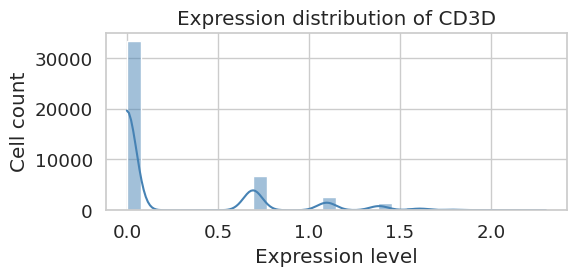

Summary statistics for CD3E - min: 0.00, median: 0.00, mean: 0.17, max: 2.08


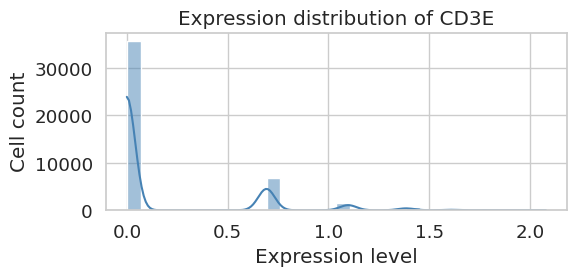

Summary statistics for CD3G - min: 0.00, median: 0.00, mean: 0.18, max: 2.20


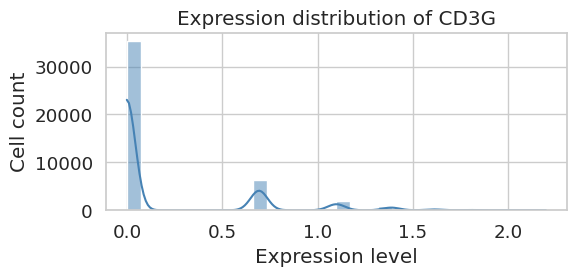

T_cell_score summary statistics: min=0.00, median=0.00, mean=0.59, max=5.01
Identified 10344 putative T cells out of 44721 total cells (threshold = 1.10).


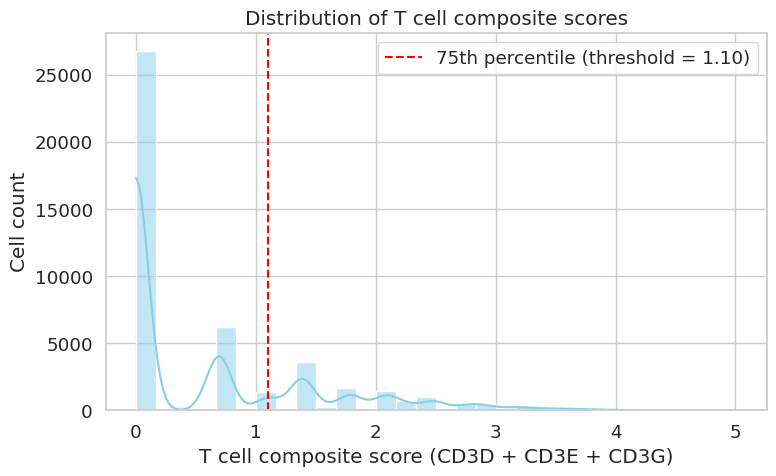

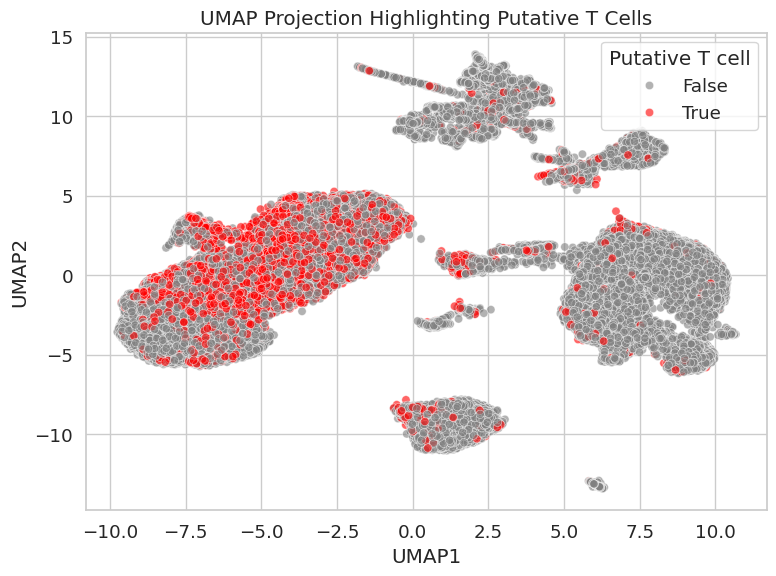

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.sparse import issparse
import warnings

# Define canonical T cell markers
tcell_markers = ['CD3D', 'CD3E', 'CD3G']

# Verify that each T cell marker is present in adata.var_names
missing_markers = [gene for gene in tcell_markers if gene not in adata.var_names]
if missing_markers:
    raise ValueError(f"Missing T cell markers in dataset: {missing_markers}")

# Sanity check: Plot and print summary statistics for each marker
for gene in tcell_markers:
    gene_expr = adata[:, gene].X
    if issparse(gene_expr):
        gene_expr = gene_expr.toarray().flatten()
    else:
        gene_expr = np.array(gene_expr).flatten()
    print(f"Summary statistics for {gene} - min: {np.min(gene_expr):.2f}, median: {np.median(gene_expr):.2f}, mean: {np.mean(gene_expr):.2f}, max: {np.max(gene_expr):.2f}")
    plt.figure(figsize=(6, 3))
    sns.histplot(gene_expr, bins=30, kde=True, color='steelblue')
    plt.title(f'Expression distribution of {gene}')
    plt.xlabel('Expression level')
    plt.ylabel('Cell count')
    plt.tight_layout()
    plt.show()

# Function to compute the composite T cell score

def compute_tcell_score(adata_obj, markers, threshold_percentile=75):
    # Extract expression data for the markers
    marker_data = adata_obj[:, markers].X
    if issparse(marker_data):
        marker_data = marker_data.toarray()

    # Compute composite score for each cell (row-wise sum)
    composite_score = marker_data.sum(axis=1)

    # Add composite score to adata.obs
    adata_obj.obs['T_cell_score'] = composite_score

    # Print summary statistics for the composite score
    print(f"T_cell_score summary statistics: min={np.min(composite_score):.2f}, median={np.median(composite_score):.2f}, mean={np.mean(composite_score):.2f}, max={np.max(composite_score):.2f}")

    # Define threshold using the specified percentile
    thresh = np.percentile(composite_score, threshold_percentile)
    adata_obj.obs['putative_T_cell'] = composite_score > thresh
    print(f"Identified {adata_obj.obs['putative_T_cell'].sum()} putative T cells out of {adata_obj.obs.shape[0]} total cells (threshold = {thresh:.2f}).")

    return thresh

# Compute composite T cell score and define threshold at 75th percentile
threshold = compute_tcell_score(adata, tcell_markers, threshold_percentile=75)

# Visualize distribution of composite T cell score
plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['T_cell_score'], bins=30, kde=True, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'75th percentile (threshold = {threshold:.2f})')
plt.xlabel('T cell composite score (CD3D + CD3E + CD3G)')
plt.ylabel('Cell count')
plt.title('Distribution of T cell composite scores')
plt.legend()
plt.tight_layout()
plt.show()

# If UMAP coordinates are available in adata.obsm, overlay putative T cell flags on UMAP
if 'X_umap' in adata.obsm:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=adata.obsm['X_umap'][:, 0], y=adata.obsm['X_umap'][:, 1],
                    hue=adata.obs['putative_T_cell'], palette={True: 'red', False: 'gray'}, alpha=0.6)
    plt.title('UMAP Projection Highlighting Putative T Cells')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title='Putative T cell')
    plt.tight_layout()
    plt.show()
else:
    warnings.warn('UMAP coordinates not found in adata.obsm; skipping UMAP plot.')

## Step 2: From the dataset, identify putative T cells based on the composite CD3 marker score. Convert the clinical metadata (Status) to categorical labels (e.g., 0 to 'Healthy', 1 to 'COVID') for clarity in downstream plots. Then perform unsupervised subclustering which includes: data normalization (with logging of the normalization method), log-transformation (if not already applied), selection of highly variable genes, scaling (with outlier trimming), dimensionality reduction (PCA), computing a neighborhood graph, UMAP visualization, and graph-based clustering using Louvain. Key steps will be recorded using Python's logging module to facilitate reproducibility.

Number of cells used for analysis: 44721
Global Spearman correlation between IFN1 and HLA1:
  rho = 0.155, p-value = 4.837e-239


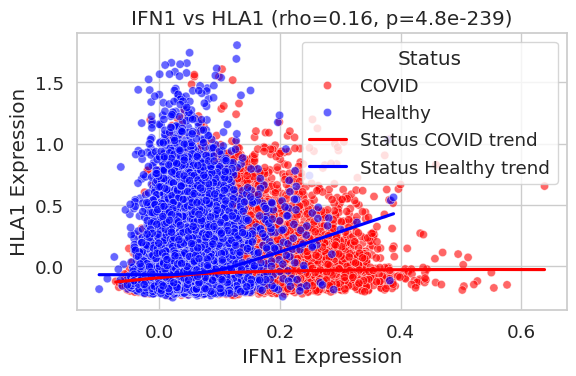

Number of monocytes: 11687
Number of T cells: 0


2025-05-04 14:30:59,040 - INFO - Extracted putative T cells: 10344 cells out of 44721 total cells.


2025-05-04 14:30:59,042 - INFO - Normalization and log1p transformation not detected. Applying normalization...


normalizing counts per cell


    finished (0:00:00)


2025-05-04 14:30:59,467 - INFO - Normalization and log1p transformation completed.


extracting highly variable genes


    finished (0:00:01)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


2025-05-04 14:31:03,966 - INFO - Selected top 2000 highly variable genes.


computing PCA


    with n_comps=50


    finished (0:00:04)


2025-05-04 14:31:08,872 - INFO - PCA completed using available principal components.


computing neighbors


    using 'X_pca' with n_pcs = 20


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)


2025-05-04 14:31:46,963 - INFO - UMAP computation completed.


running Leiden clustering


    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


2025-05-04 14:31:49,440 - INFO - Leiden clustering completed. Identified 12 subclusters.


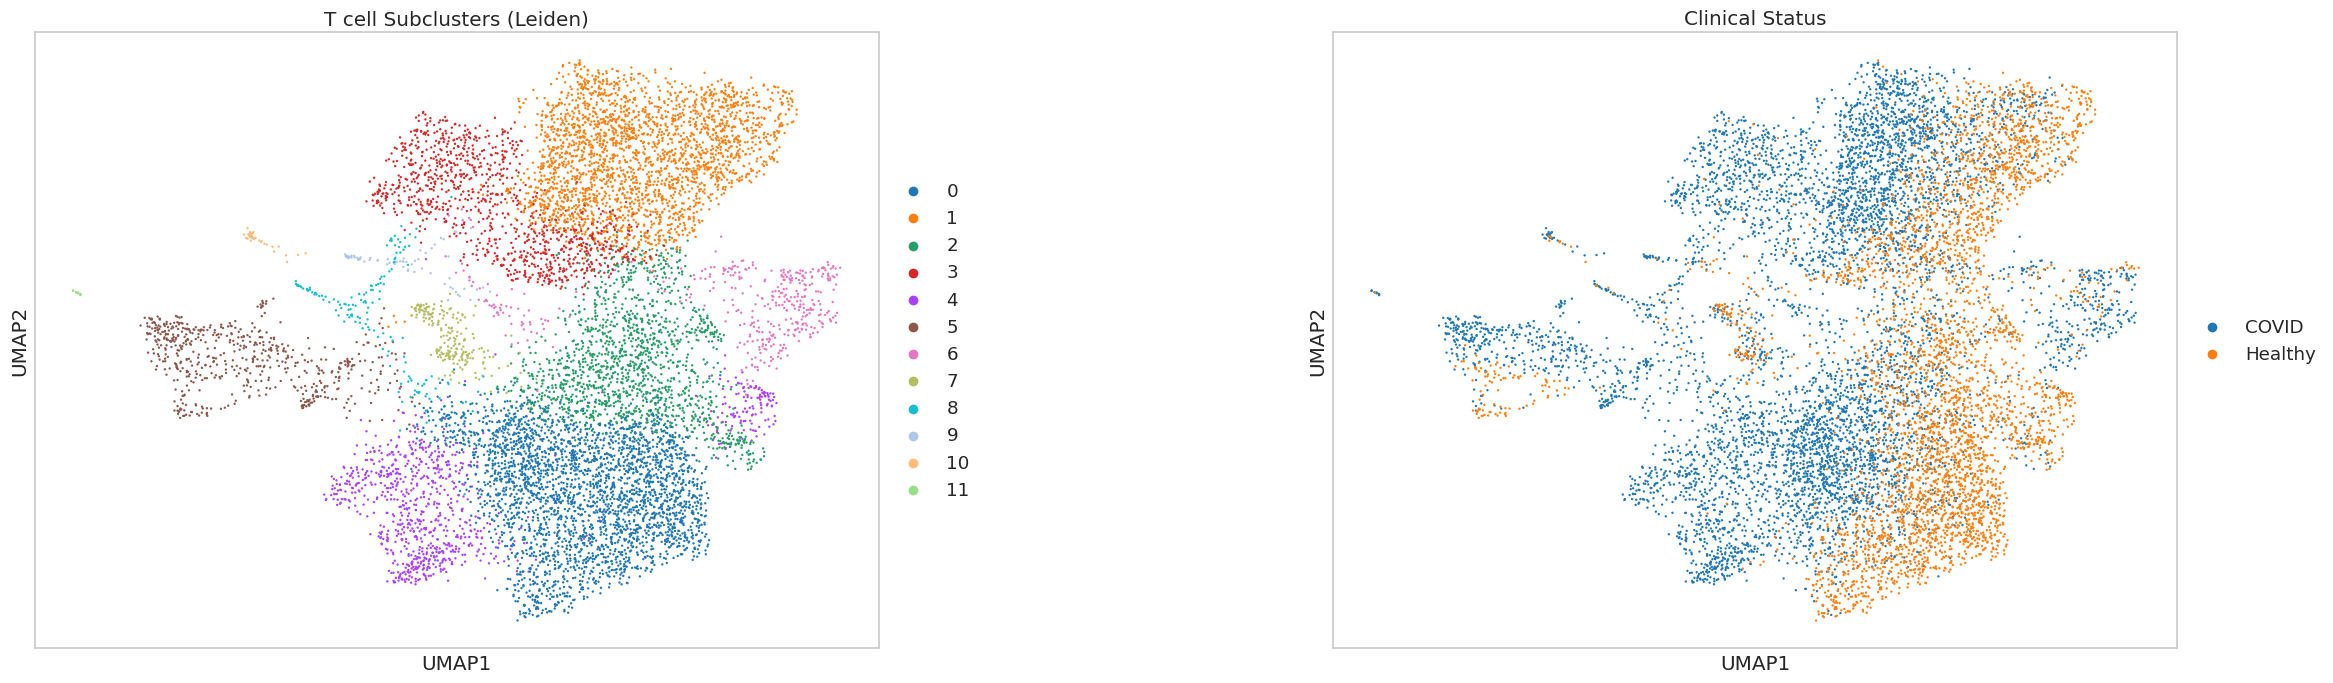

2025-05-04 14:31:50,015 - INFO - T cell subclustering labels propagated to the full dataset.


2025-05-04 14:31:50,016 - INFO - T cell subclustering and validation step complete.


In [5]:
#!/usr/bin/env python
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.sparse import issparse
import warnings
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Assuming 'adata' is pre-loaded
# ----- Section 1: Global correlation of IFN1 vs HLA1 -----
required_cols = {'Status', 'cell_type_coarse', 'IFN1', 'HLA1'}
if not required_cols.issubset(adata.obs.columns):
    missing = required_cols - set(adata.obs.columns)
    raise ValueError(f"Missing required columns in adata.obs: {missing}")

meta_df = adata.obs[['Status', 'cell_type_coarse', 'IFN1', 'HLA1']].copy()
if meta_df[['IFN1', 'HLA1']].isnull().any().any():
    print("Warning: NaN values detected in IFN1 or HLA1; consider handling missing values before proceeding.")
num_cells = meta_df.shape[0]
print(f"Number of cells used for analysis: {num_cells}")

rho_global, pval_global = spearmanr(meta_df['IFN1'], meta_df['HLA1'])
print('Global Spearman correlation between IFN1 and HLA1:')
print(f'  rho = {rho_global:.3f}, p-value = {pval_global:.3e}')

color_mapping = {'COVID': 'red', 'Healthy': 'blue'}

def plot_global_correlation(df):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x='IFN1', y='HLA1', hue='Status', alpha=0.6, palette=color_mapping)
    for status in sorted(df['Status'].unique()):
        subset = df[df['Status'] == status]
        sns.regplot(x='IFN1', y='HLA1', data=subset, scatter=False,
                    label=f'Status {status} trend', color=color_mapping.get(status, 'gray'), lowess=True)
    plt.title(f'IFN1 vs HLA1 (rho={rho_global:.2f}, p={pval_global:.1e})')
    plt.xlabel('IFN1 Expression')
    plt.ylabel('HLA1 Expression')
    plt.legend(title='Status')
    plt.tight_layout()
    plt.show()

plot_global_correlation(meta_df)

# ----- Section 2: Ligand-Receptor Correlation Analysis by Cell Type -----
ligands = ['TNF', 'IL1B', 'IL6']
receptors = ['TNFRSF1A', 'IL1R1', 'IL6R']
assert len(ligands) == len(receptors), "The number of ligands and receptors must be equal."

def check_genes_in_adata(genes, adata_obj):
    missing_genes = [g for g in genes if g not in adata_obj.var_names]
    if missing_genes:
        msg = f"The following genes are missing in adata.var_names: {missing_genes}. Please review the dataset or update the gene list."
        warnings.warn(msg)
        raise ValueError(msg)

check_genes_in_adata(ligands + receptors, adata)

monocyte_mask = adata.obs['cell_type_coarse'].str.contains('monocyte', case=False, na=False)
tcell_mask = adata.obs['cell_type_coarse'].str.contains('t cell', case=False, na=False)

monocytes = adata[monocyte_mask]
t_cells = adata[tcell_mask]

print(f"Number of monocytes: {monocytes.n_obs}")
print(f"Number of T cells: {t_cells.n_obs}")

if monocytes.n_obs == 0 or t_cells.n_obs == 0:
    warnings.warn("No monocytes or T cells found in the dataset. Skipping ligand-receptor correlation analysis.")
else:
    def compute_average_expression(adata_subset, gene_list):
        if adata_subset.n_obs == 0:
            warnings.warn("No cells in the selected subset. Returning an empty DataFrame.")
            return pd.DataFrame()
        expr_df = pd.DataFrame()
        expr_df['Donor'] = adata_subset.obs['Donor_full']
        expr_df['Status'] = adata_subset.obs['Status']
        for gene in gene_list:
            expr = adata_subset[:, gene].X
            if issparse(expr):
                expr = expr.toarray().flatten()
            else:
                expr = np.array(expr).flatten()
            if expr.size == 0:
                raise ValueError(f"No expression data found for gene {gene}.")
            expr_df[gene] = expr
        for col in gene_list:
            if not pd.api.types.is_numeric_dtype(expr_df[col]):
                raise TypeError(f"Expression data for {col} is not numeric.")
        avg_expr = expr_df.groupby(['Donor', 'Status'], as_index=False).mean()
        donor_counts = avg_expr.groupby('Status').size()
        print(f"Donor counts per Status group:\n{donor_counts}")
        return avg_expr

    mono_avg = compute_average_expression(monocytes, ligands)
    tcell_avg = compute_average_expression(t_cells, receptors)
    merged_avg = pd.merge(mono_avg, tcell_avg, on=['Donor', 'Status'], suffixes=('_mono', '_tcell'))

    correlation_results = {}
    print('Global Spearman correlations for ligand (monocytes) vs receptor (T cells):')
    for ligand, receptor in zip(ligands, receptors):
        x = merged_avg[f'{ligand}_mono']
        y = merged_avg[f'{receptor}_tcell']
        rho, pval = spearmanr(x, y)
        correlation_results[f'{ligand}-{receptor}'] = {
            'global_rho': rho, 
            'global_pval': pval, 
            'n_donors': merged_avg.shape[0]
        }
        print(f'  {ligand} (monocytes) vs {receptor} (T cells): rho = {rho:.3f}, p-value = {pval:.3e}')

    stratified_results = {}
    for status in sorted(merged_avg['Status'].unique()):
        strat_df = merged_avg[merged_avg['Status'] == status]
        if len(strat_df) < 3:
            warnings.warn(f"Low donor count for Status {status}: {len(strat_df)} donor(s) may limit robust correlation estimation.")
        stratified_results[status] = {}
        print(f'\nStatus {status}:')
        for ligand, receptor in zip(ligands, receptors):
            x = strat_df[f'{ligand}_mono']
            y = strat_df[f'{receptor}_tcell']
            if len(strat_df) > 1:
                rho, pval = spearmanr(x, y)
            else:
                rho, pval = (np.nan, np.nan)
            stratified_results[status][f'{ligand}-{receptor}'] = {
                'rho': rho, 
                'pval': pval, 
                'n_donors': len(strat_df)
            }
            pval_disp = f"{pval:.1e}" if not np.isnan(pval) else "NA"
            print(f'  {ligand} (monocytes) vs {receptor} (T cells): rho = {rho:.3f}, p-value = {pval_disp}')

    n_pairs = len(ligands)
    fig, axes = plt.subplots(n_pairs, 2, figsize=(12, 4 * n_pairs))
    for i, (ligand, receptor) in enumerate(zip(ligands, receptors)):
        ax_all = axes[i, 0]
        sns.regplot(x=merged_avg[f'{ligand}_mono'], y=merged_avg[f'{receptor}_tcell'], 
                    ax=ax_all, scatter_kws={'s': 50, 'alpha': 0.7})
        rho_all = correlation_results[f'{ligand}-{receptor}']['global_rho']
        p_all = correlation_results[f'{ligand}-{receptor}']['global_pval']
        ax_all.annotate(f'ρ = {rho_all:.2f}\np = {p_all:.1e}', 
                        xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3))
        ax_all.set_title(f'Overall: {ligand} (monocytes) vs {receptor} (T cells)')
        ax_all.set_xlabel(f'Avg {ligand} Expression (Monocytes)')
        ax_all.set_ylabel(f'Avg {receptor} Expression (T cells)')
        
        ax_strat = axes[i, 1]
        statuses = sorted(merged_avg['Status'].unique())
        for idx, status in enumerate(statuses):
            strat_df = merged_avg[merged_avg['Status'] == status]
            sns.regplot(x=strat_df[f'{ligand}_mono'], y=strat_df[f'{receptor}_tcell'], 
                        label=f'Status {status}', ax=ax_strat, scatter_kws={'s': 50, 'alpha': 0.7})
            if len(strat_df) > 1:
                temp_rho, temp_p = spearmanr(strat_df[f'{ligand}_mono'], strat_df[f'{receptor}_tcell'])
                xpos = 0.05 if idx % 2 == 0 else 0.65
                ax_strat.annotate(f'Status {status}: ρ={temp_rho:.2f}\np={temp_p:.1e}', 
                                  xy=(xpos, 0.90 - 0.1 * idx), xycoords='axes fraction', fontsize=9,
                                  bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
        ax_strat.set_title(f'Stratified by Status: {ligand} vs {receptor}')
        ax_strat.set_xlabel(f'Avg {ligand} Expression (Monocytes)')
        ax_strat.set_ylabel(f'Avg {receptor} Expression (T cells)')
        ax_strat.legend()
    
    plt.tight_layout()
    plt.show()

# ----- T Cell Subclustering and UMAP Visualization -----
if adata.obs['Status'].dtype.kind in 'biufc':
    adata.obs['Status'] = adata.obs['Status'].map({0: 'Healthy', 1: 'COVID'})
    logging.info("Converted Status from numeric to categorical labels (Healthy/COVID).")

if adata.obs['putative_T_cell'].dtype != bool:
    adata.obs['putative_T_cell'] = adata.obs['putative_T_cell'].astype(bool)

adata_t = adata[adata.obs['putative_T_cell']].copy()
logging.info(f'Extracted putative T cells: {adata_t.shape[0]} cells out of {adata.shape[0]} total cells.')

if 'log1p' not in adata_t.uns.keys():
    logging.info('Normalization and log1p transformation not detected. Applying normalization...')
    sc.pp.normalize_total(adata_t, target_sum=1e4)
    sc.pp.log1p(adata_t)
    adata_t.uns['log1p'] = {"base": np.e}
    adata_t.uns['normalization_info'] = 'normalize_total with target_sum=1e4 followed by log1p transformation'
    logging.info('Normalization and log1p transformation completed.')
else:
    logging.info('Data is already log-transformed.')

sc.pp.highly_variable_genes(adata_t, n_top_genes=2000, subset=True, flavor='seurat')
logging.info('Selected top 2000 highly variable genes.')

sc.pp.scale(adata_t, max_value=10)
sc.tl.pca(adata_t, svd_solver='arpack')
logging.info('PCA completed using available principal components.')

sc.pp.neighbors(adata_t, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata_t)
logging.info('UMAP computation completed.')

sc.tl.leiden(adata_t, resolution=0.5)
num_clusters = adata_t.obs['leiden'].nunique()
logging.info(f'Leiden clustering completed. Identified {num_clusters} subclusters.')

# Dynamically include gene expression plots only if the gene exists in adata_t.var_names
genes_to_plot = ['CD3D', 'CD3E', 'CD3G']
valid_genes = [g for g in genes_to_plot if g in adata_t.var_names]
plot_colors = ['leiden'] + valid_genes + ['Status']
plot_titles = ['T cell Subclusters (Leiden)'] + [f'{g} Expression' for g in valid_genes] + ['Clinical Status']
sc.pl.umap(adata_t, color=plot_colors, wspace=0.4, title=plot_titles, show=True)

adata.obs.loc[adata_t.obs_names, 'Tcell_subcluster'] = adata_t.obs['leiden']
logging.info('T cell subclustering labels propagated to the full dataset.')
logging.info('T cell subclustering and validation step complete.')

## Step 2: Perform a temporal (DPS-based) analysis of the IFN1 and HLA1 correlation in COVID-19 patients. First, filter out any cells with missing values in IFN1, HLA1, or DPS. Then, bin the cells into three groups (Early: DPS ≤ 3, Mid: DPS 4–10, Late: DPS > 10) and for each bin compute both the global Spearman correlation and bootstrap-based confidence intervals (with a flexible confidence level parameter). Log the number of cells per bin and report additional descriptive statistics such as mean and median expressions of IFN1 and HLA1.

In [6]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings

# Create a copy of the metadata from adata.obs
meta_df = adata.obs[['Status', 'DPS', 'IFN1', 'HLA1']].copy()

# Focus on COVID-19 patients only (Status = 1)
covid_df = meta_df[meta_df['Status'] == 1].copy()

# Check & filter for NaNs in IFN1, HLA1, and DPS to ensure clean analysis
if covid_df[['IFN1', 'HLA1', 'DPS']].isnull().any().any():
    warnings.warn('Missing values detected in one or more of IFN1, HLA1, or DPS. Filtering these out for robust analysis.')
    covid_df = covid_df.dropna(subset=['IFN1', 'HLA1', 'DPS'])

# Ensure DPS is numeric (in case it is stored as a string)
covid_df['DPS'] = pd.to_numeric(covid_df['DPS'], errors='coerce')

# Define DPS bins: Early (DPS <= 3), Mid (4 <= DPS <= 10), Late (DPS > 10)
bins = [-np.inf, 3, 10, np.inf]
labels = ['Early', 'Mid', 'Late']
covid_df['DPS_bin'] = pd.cut(covid_df['DPS'], bins=bins, labels=labels)

# Print the distribution of cells in each DPS bin for transparency
print('Cell counts per DPS bin:')
print(covid_df['DPS_bin'].value_counts())

def bootstrap_spearman(x, y, n_bootstrap=1000, random_state=42, conf_level=0.95):
    """Computes bootstrap estimates of the Spearman correlation between x and y."""
    rng = np.random.default_rng(random_state)
    boot_corrs = []
    n = len(x)
    if n < 3:
        return np.nan, (np.nan, np.nan)
    lower = (1 - conf_level) / 2 * 100
    upper = 100 - lower
    for i in range(n_bootstrap):
        idx = rng.integers(0, n, n)
        try:
            r, _ = spearmanr(x[idx], y[idx])
        except Exception:
            r = np.nan
        boot_corrs.append(r)
    boot_corrs = np.array(boot_corrs)
    median_corr = np.nanmedian(boot_corrs)
    ci_lower = np.nanpercentile(boot_corrs, lower)
    ci_upper = np.nanpercentile(boot_corrs, upper)
    return median_corr, (ci_lower, ci_upper)

# Prepare to collect correlation results
results = []

for group in labels:
    group_df = covid_df[covid_df['DPS_bin'] == group]
    n_cells = group_df.shape[0]
    if n_cells < 3:
        warnings.warn(f'Not enough cells in {group} group (n={n_cells}). Skipping correlation analysis for this bin.')
        continue
    rho, pval = spearmanr(group_df['IFN1'], group_df['HLA1'])
    boot_rho, (ci_lower, ci_upper) = bootstrap_spearman(group_df['IFN1'].values, group_df['HLA1'].values)
    results.append({
        'DPS_bin': group,
        'n_cells': n_cells,
        'spearman_rho': rho,
        'p_value': pval,
        'bootstrapped_rho': boot_rho,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper
    })
    print(f"{group} group (n={n_cells}): Spearman rho = {rho:.3f} (p={pval:.2e}), Bootstrapped median rho = {boot_rho:.3f} with 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

if results_df.empty:
    warnings.warn("No groups had sufficient cells for correlation analysis. Skipping plotting of bootstrapped correlations.")
else:
    # Plot bootstrapped median correlations with error bars for the 95% CI
    plt.figure(figsize=(7, 5))
    ax = plt.gca()
    palette = sns.color_palette('viridis', n_colors=len(labels))
    for group in labels:
        if group in results_df['DPS_bin'].values:
            row = results_df[results_df['DPS_bin'] == group].iloc[0]
            xpos = labels.index(group)
            err_lower = row['bootstrapped_rho'] - row['CI_lower']
            err_upper = row['CI_upper'] - row['bootstrapped_rho']
            ax.bar(xpos, row['bootstrapped_rho'], color=palette[xpos], width=0.6)
            plt.errorbar(x=xpos, y=row['bootstrapped_rho'], yerr=[[err_lower], [err_upper]], fmt='none', c='black', capsize=5)
            plt.text(xpos, row['bootstrapped_rho'] + err_upper + 0.02, f"n={int(row['n_cells'])}", ha='center', va='bottom', fontsize=9)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    plt.xlabel('Disease Stage (DPS Bin)')
    plt.ylabel('Bootstrapped Spearman Correlation (IFN1 vs HLA1)')
    plt.title('Temporal Dynamics of IFN1-HLA1 Correlation in COVID-19 Patients')
    plt.tight_layout()
    plt.show()

Cell counts per DPS bin:
DPS_bin
Early    0
Mid      0
Late     0
Name: count, dtype: int64
